In [1]:
#IMPORTANT: Need to install igraph and pycairo for plots
#conda install -c marufr python-igraph
#conda install pycairo

#import packages
import igraph
import numpy as np
import pandas as pd
import datetime as dt
import statistics as stat
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
#Read in Data
#Full
data_full=np.loadtxt("Edgelists/email-Eu-core-temporal.txt")
data_full=data_full.astype(int)

#ground truth
data_gt=np.loadtxt("Edgelists/email-Eu-core.txt")
data_gt=data_gt.astype(int)

#Department Labels
dep_lab=np.loadtxt("email-Eu-core-department-labels.txt")
dep_lab=dep_lab.astype(int)

In [3]:
#Sort data
data_full=data_full[data_full[:,2].argsort(axis=0)]


In [4]:
#Constructing a Network for the regular email EU
el_2=data_gt[:,0:2]
el_2=list(map(tuple, el_2))

#Create Graph With Weights
g2=igraph.Graph(el_2)
g2.es["Weight"]=1

#Name Vertices With VID
g2.vs["id"] = range(g2.vcount())

#Assign Departments
g2.vs["dep"] = dep_lab[:,1]

#Simplify Graph and create edgelist
g_simp_2=g2.simplify(multiple=True, loops=True, combine_edges=sum)

#Remove Isolated Vertices
g_simp_2.vs.select(_degree=0).delete() 

#g_simp.vs["label"]=g_simp.vs["RAK"]
g_simp_2.vs["size"]=7

#Plot
#igraph.plot(g_simp_2)

#Very nice! Still got it!

In [5]:
#Count Department Membership
unique, counts = np.unique(dep_lab[:,1], return_counts=True)
dep_members=dict(zip(unique, counts))
print(dep_members)

{0: 49, 1: 65, 2: 10, 3: 12, 4: 109, 5: 18, 6: 28, 7: 51, 8: 19, 9: 32, 10: 39, 11: 29, 12: 3, 13: 26, 14: 92, 15: 55, 16: 25, 17: 35, 18: 1, 19: 29, 20: 14, 21: 61, 22: 25, 23: 27, 24: 6, 25: 6, 26: 9, 27: 10, 28: 8, 29: 5, 30: 4, 31: 8, 32: 9, 33: 1, 34: 13, 35: 13, 36: 22, 37: 15, 38: 13, 39: 3, 40: 4, 41: 2}


In [6]:
#Get ground truth groups (4,14,1,21,15) and high-level statistics
#For loop
for n in (4,14,1,21,15):
    dep_id1=g_simp_2.vs.select(dep_eq=n)["id"]
    dep1=g_simp_2.vs.select(id_in=dep_id1)
    dep1_deg=np.asarray(dep1.degree())
    gt_g1=g_simp_2.subgraph(dep1)

    print("dep: ",n)
    print("mean deg: ",np.mean(dep1_deg))
    print("deg stdev: ",np.std(dep1_deg))
    print("diameter: ",gt_g1.diameter())
    print("")

dep:  4
mean deg:  31.57943925233645
deg stdev:  35.0820233496072
diameter:  5

dep:  14
mean deg:  30.593406593406595
deg stdev:  26.28958679989868
diameter:  4

dep:  1
mean deg:  26.35483870967742
deg stdev:  25.60877922434184
diameter:  5

dep:  21
mean deg:  28.767857142857142
deg stdev:  31.401769212798783
diameter:  4

dep:  15
mean deg:  26.01851851851852
deg stdev:  27.142621083578025
diameter:  4



[ 78  40  89  85  46 162 106  68  75  90  33 171  35  36  49  34  55   7
  39  59  28  89 127  15  34   9 120  81  27  36  23  18  49  18  28  99
  35  58  69  72  27  47  47  20  72  86  43   3  19  61   5  18  41  28
   8  30  19   4  28  24   4  19   4  11  11  26   2  10   1  30  11   1
   2   9   2   7  12  23   4   5  11   1   6   2   5  24   5  20   4   7
   4  16   2   3   2   3   1   8   1  25   1   2   1   1   1   1   6]


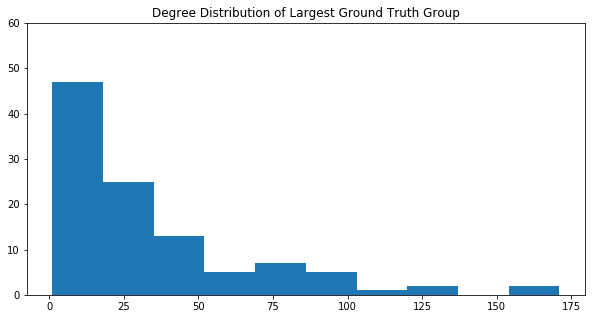

In [7]:
#Degree Histograms
#Define group we want to look at
dep_id=4

#Get stats and create subgraph
dep_id1=g_simp_2.vs.select(dep_eq=dep_id)["id"]
dep1=g_simp_2.vs.select(id_in=dep_id1)
dep1_deg=np.asarray(dep1.degree())
print(dep1_deg)
gt_g1=g_simp_2.subgraph(dep1)

#Plot histogram
plt.figure(figsize=(10,5))
plt.title("Degree Distribution of Largest Ground Truth Group")
plt.ylim(0,60)
plt.hist(dep1_deg)
plt.show()

In [8]:
###Graph setup for temporal graph
#Edgelist for full graph
el_full=data_full[:,0:2]
el_full=list(map(tuple, el_full))

#Create Graph With Weights
g_full=igraph.Graph(el_full)
g_full.es["Weight"]=1

#Name Vertices With VID
g_full.vs["id"] = range(g_full.vcount())

#Remove Isolated Vertices
g_full.vs.select(_degree=0).delete() 

#Simplify Graph and create edgelist
g_simp=g_full.simplify(multiple=True, loops=True, combine_edges=sum)

g_full.summary()

'IGRAPH U--- 986 16064 -- \n+ attr: id (v), Weight (e)'

In [16]:
#ALGORITHM INITIALIZATION
#Pandas
import pandas as pd
import random

#RAK Initialization
g_simp.vs["RAK"]=range(len(g_simp.vs))

#Print to confirm
#print(g_simp.vs["RAK"])

#ALGORITHM
#Parameters
iterations=10
rand_seed=0

#set random seed
random.seed(rand_seed)

#iterate that many times
for t in range(iterations):
    
    #Shuffle order of vertices for asynchronous updates
    order=list(range(len(g_simp.vs)))
    random.shuffle(order)

    #Loop over random order
    for v in order:
        #print(v)
        
       #Get Neighbors
        neighbors=g_simp.vs.select(g_simp.neighbors(v))

        #Initialize Vectors
        labels=[0]*len(neighbors)
        weights=[0]*len(neighbors)
        ind=0

        for n in neighbors:
            #Get Label
            labels[ind]=n["RAK"]

            #Get Weights
            weights[ind]= g_simp.es.select(g_simp.get_eid(v, n))["Weight"][0]

            #increase ind
            ind+=1

        #Create Data Frame
        df= pd.DataFrame()
        df['Label'] = labels
        df['Weight'] = weights

        #Sum Columns with Same Label
        df=df.groupby(["Label"])["Weight"].sum().reset_index()

        #Find Max Label
        Best_Label=list(df[df['Weight']==df['Weight'].max()]["Label"])
        
        #If more than one, choose label randomly
        if len(Best_Label)>1:
            Best_Label=Best_Label[random.randint(0,len(Best_Label)-1)]                   
        
        #print("Best Label: ", Best_Label)

        #Set new label
        g_simp.vs.select(v)["RAK"]=Best_Label
        
        #Clear Memory
        del(labels,weights, df)
 

    #Show All Labels
    print("t=",t+1," Done!")
    #print("Labels at t=",t,": ", g.vs["RAK"])
    
#Use a Counter to find most occuring
RAK_count=Counter(g_simp.vs["RAK"])
print(RAK_count)

t= 1  Done!
t= 2  Done!
t= 3  Done!
t= 4  Done!
t= 5  Done!
t= 6  Done!
t= 7  Done!
t= 8  Done!
t= 9  Done!
t= 10  Done!
Counter({107: 86, 336: 76, 166: 73, 702: 66, 968: 56, 262: 47, 176: 40, 300: 37, 722: 36, 517: 33, 48: 33, 135: 32, 959: 30, 62: 30, 897: 28, 146: 23, 494: 22, 120: 21, 419: 19, 40: 18, 730: 18, 958: 15, 157: 15, 715: 13, 593: 13, 363: 12, 188: 10, 940: 10, 531: 8, 354: 8, 408: 6, 545: 5, 433: 5, 878: 4, 225: 4, 831: 4, 370: 4, 414: 4, 944: 3, 413: 3, 268: 3, 929: 3, 891: 2, 888: 2, 438: 2, 428: 2, 533: 2})


In [17]:
#Plot Resulting Communities with Colors
#Create Palette
labels=list(set(g_simp.vs["RAK"]))
palette = igraph.RainbowPalette(n=len(labels))

#remap labels to color palette
colors=[0]*len(g_simp.vs)
ind=0
for v in g_simp.vs:
    colors[ind]=labels.index(v["RAK"])
    ind+=1

#Label Vertices With Label
#g_simp.vs["label"]=g_simp.vs["RAK"]
g_simp.vs["size"]=7
g_simp.vs["color"]=palette.get_many(colors)

#Plot
igraph.plot(g_simp)

In [53]:
#Get Membership and store in dictionary
members={}

for R in labels:
    #print('Group:', R, "| Members: ",g_simp.vs.select(RAK_eq=R).indices)
    members[R]=g_simp.vs.select(RAK_eq=R)["id"]

#Put groups and number of membership in numpy array
ranking=np.zeros((len(members),2))
ind=0
for m in members:
    ranking[ind,0]=m
    ranking[ind,1]=len(members[m])
    ind+=1

#sort and get top five
topfive=ranking[ranking[:,1].argsort()[::-1]][0:5,0]
#print(topfive)

In [54]:
#Get High-Level Statistics for top five groups
#Let's throw this in a for loop
for n in topfive:  
    alg_dep1=g_simp.vs.select(id_in=members[n])
    alg_dep1_deg=np.asarray(alg_dep1.degree())
    alg_g1=g_simp.subgraph(alg_dep1)
    
    print("group label: ",n)
    print("mean degree: ",np.mean(alg_dep1_deg))
    print("degree stdev: ",np.std(alg_dep1_deg))
    print("diameter of subgraph: ",alg_g1.diameter())
    print("")

group label:  107.0
mean degree:  36.69767441860465
degree stdev:  49.78443526436422
diameter of subgraph:  6

group label:  336.0
mean degree:  32.75
degree stdev:  27.169606180436254
diameter of subgraph:  4

group label:  166.0
mean degree:  35.87671232876713
degree stdev:  40.05234424602606
diameter of subgraph:  4

group label:  702.0
mean degree:  31.939393939393938
degree stdev:  37.45254726453713
diameter of subgraph:  5

group label:  968.0
mean degree:  31.785714285714285
degree stdev:  24.343314046684572
diameter of subgraph:  4



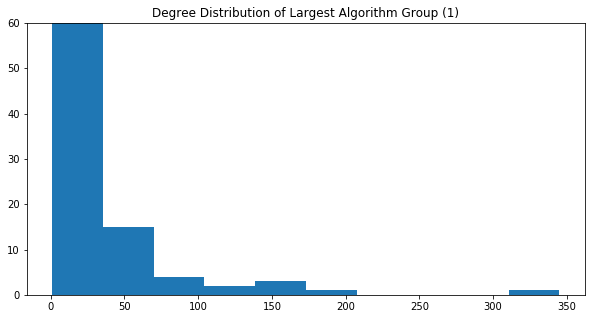

In [55]:
#Degree Histograms
#Define group we want to look at
group=topfive[0]

#Get stats and create subgraph
alg_dep1=g_simp.vs.select(id_in=members[group])
alg_dep1_deg=np.asarray(alg_dep1.degree())
#print(alg_dep1_deg)
alg_g1=g_simp.subgraph(alg_dep1)

#Plot histogram
plt.figure(figsize=(10,5))
plt.hist(alg_dep1_deg)
plt.ylim(0,60)
plt.title("Degree Distribution of Largest Algorithm Group (1)")
plt.show()

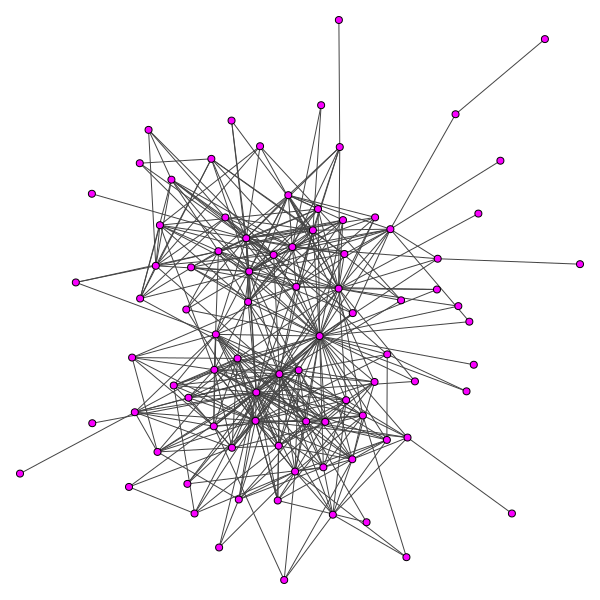

In [56]:
igraph.plot(alg_g1)

In [57]:
#Markov Clustering Test
import markov_clustering as mc
import networkx as nx

In [58]:
##Create Weighted Edgelist
#Variables
size=len(g_simp.es)
n=0

#Define list
el_weighted=[0]*size

#For Loop
for e in g_simp.es:
    
    #Get info
    s=e.source
    t=e.target
    w=e['Weight']
    
    #Create Tuple
    tup=(s,t,w)
    
    #Store
    el_weighted[n]=tup
    
    #Increase Index
    n+=1


#print(el_weighted)

In [59]:
#Create Networkx graph with weighted edges
G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_weighted_edges_from(el_weighted)
matrix = nx.to_scipy_sparse_matrix(G) #Create Weighted edgelist

In [60]:
#Test for correct index matching
for i in range(len(g_simp.vs)):
    
    if G.degree[i]!=g_simp.vs(i).degree()[0]:
        print("AHHHHHH!")
#i=6
#print(G.degree[i])
#print(g_simp.vs(i).degree()[0])

39
39


In [62]:
result = mc.run_mcl(matrix)           # run MCL with default parameters
clusters = mc.get_clusters(result)    # get clusters

In [78]:
#Get top 5 markovian clusters
print(len(clusters))
#Put groups and number of membership in numpy array
ranking_m=np.zeros((len(clusters),2))
ind=0
for c in range(len(clusters)):
    ranking_m[ind,0]=c
    ranking_m[ind,1]=len(clusters[c])
    ind+=1

#sort and get top five
topfive_m=ranking_m[ranking_m[:,1].argsort()[::-1]][0:5,0]
print(topfive_m)

87
[10.  4.  0. 34. 28.]


In [80]:
#Features of largest group
top_ind=int(topfive_m[0])

print(len(clusters[top_ind]))
print(np.mean(g_simp.vs(clusters[top_ind]).degree()))
print(np.std(g_simp.vs(clusters[top_ind]).degree()))

63
34.55555555555556
38.2940907944127


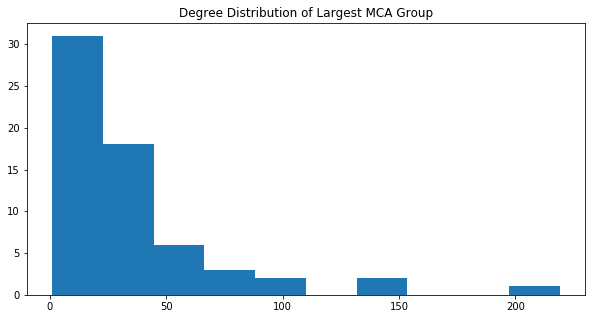

In [81]:
#Degree Histograms
#Define group we want to look at
group=int(topfive_m[0])

#Get stats and create subgraph
mca_dep1_deg=np.asarray(g_simp.vs(clusters[group]).degree())

#Plot histogram
plt.figure(figsize=(10,5))
plt.hist(mca_dep1_deg)
plt.title("Degree Distribution of Largest MCA Group")
plt.show()